# Control in a continuous action space with DDPG
_Authors:_ Aristotelis Dimitriou, Konstantinos Spinakis

---

### Introduction

In this reinforcement learning project, we implement the Deep Deterministic Policy Gradient (DDPG) algorithm to handle continuous action spaces while maintaining the benefits of Deep Q-learning (DQN). The objective is to stabilize an inverted pendulum in the Pendulum-v1 environment from OpenAI Gym.

DDPG is an actor-critic algorithm that utilizes one neural network (critic) to estimate the Q function and another (actor) to select the action. It is based on the deterministic policy gradient theorem, allowing both the actor and critic to be trained off-policy from a replay buffer. The policy network outputs a specific action instead of a probability distribution, enabling a flexible exploration strategy.

* The `Pendulum-v1` environment provides a three-dimensional observation vector $(\cos(\alpha), \sin(\alpha), \dot{\alpha})$ where $\alpha$ represents the angle between the pendulum and the vertical line. 

* The action is a scalar value between -2 and 2, representing the torque applied to the pendulum's unique joint. 

* The control policy must learn to swing the pendulum to gain momentum before stabilizing it in a vertical position with minimal torque. 

* The reward function is defined as $-(\alpha^2 + 0.1\cdot\dot{\alpha}^2 + 0.001\cdot\tau^2)$, with the maximum reward of 0 achieved when the pendulum is vertically positioned, motionless, and with no torque applied.


In [150]:
import gym
import numpy as np
from helpers import NormalizedEnv, RandomAgent
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output


___
### Heuristic Policy

In this section, we will familiarize ourselves with the `Pendulum-v1` environment by implementing a simple heuristic policy to attempt stabilizing the pendulum. We will compare the heuristic policy with a random policy to verify the increase in average reward.

_**Tasks:**_


1. Create an instance of the `Pendulum-v1` environment and wrap it in a `NormalizedEnv` class.

In [151]:
env = NormalizedEnv(gym.make('Pendulum-v1'))

2. Implement a functions that simulates an interaction between the environment and the agent. Returning the average cumulative reward.

In [152]:
def run_agent(agent, env, episodes=10, store_positions=False, verbose=False):
    rewards = []
    positions = []

    for i in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        episode_positions = []
        done = False
        step = 1
                

        while not done:
            if verbose:
                print(f'* Episode {i+1}/{episodes}')
                print(f'Step {step}')
                
            action = agent.compute_action(state)
            next_state, reward, _, done, _ = env.step(action)
            total_reward += reward
            state = next_state
            x, y, a_dot = state
            step += 1
            if store_positions:
                episode_positions.append((x, y))

            if verbose:
                print(f'\tS: ({x:.2f}, {y:.2f}, {a_dot:.2f})', end='\t')
                print(f'\tA: {action[0]:.2f}', end='\t')
                print(f'\tR: {reward:.2f}', end='\t')
                print(f'\tD: {done}')
                print('----------------------')
        rewards.append(total_reward)
        if store_positions:
            positions.append(episode_positions)
    return np.mean(rewards), rewards, positions if store_positions else None


3. Implement a heuristic policy for the pendulum (`HeuristicPendulumAgent`).

In [153]:
class HeuristicPendulumAgent:
    def __init__(self, env, fixed_torque=0.5, verbose=False):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.shape[0]
        self.fixed_torque = fixed_torque
        self.verbose = verbose

    def compute_action(self, state):
        x, y, angular_velocity = state

        if self.verbose:
            if x < 0:
                print('Lower half of the domain')
            else:
                print('Upper half of the domain')

        if x < 0:   # Lower half of the domain
            action = np.sign(angular_velocity) * self.fixed_torque
        else:       # Upper half of the domain
            action = -np.sign(angular_velocity) * self.fixed_torque
        return np.array([action])


5. Compare the average cumulative reward obtained by the heuristic policy and compare it with the reward of the random agent.

Random agent average reward: -1162.12
Heuristic agent average reward: -472.59


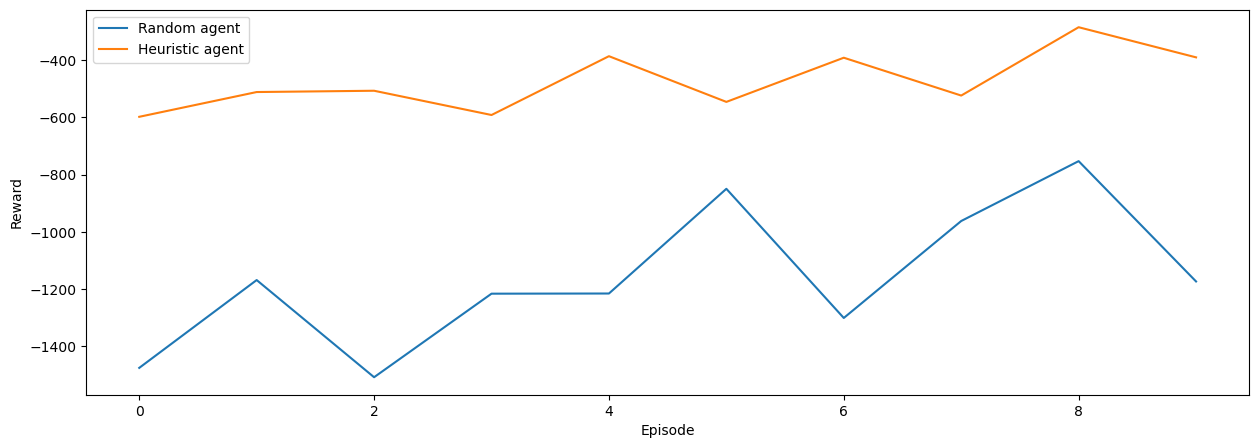

In [154]:
verbose = False

heuristic_agent = HeuristicPendulumAgent(env, fixed_torque=1, verbose=verbose)
random_agent = RandomAgent(env, verbose=verbose)

ha_avg_reward, ha_rewards, _  = run_agent(heuristic_agent, env, episodes=10, verbose=verbose)
ra_avg_reward, ra_rewards, _ = run_agent(random_agent, env, episodes=10, verbose=verbose)
print(f'Random agent average reward: {ra_avg_reward:.2f}')
print(f'Heuristic agent average reward: {ha_avg_reward:.2f}')

plt.figure(figsize=(15, 5))
plt.plot(ra_rewards, label='Random agent')
plt.plot(ha_rewards, label='Heuristic agent')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

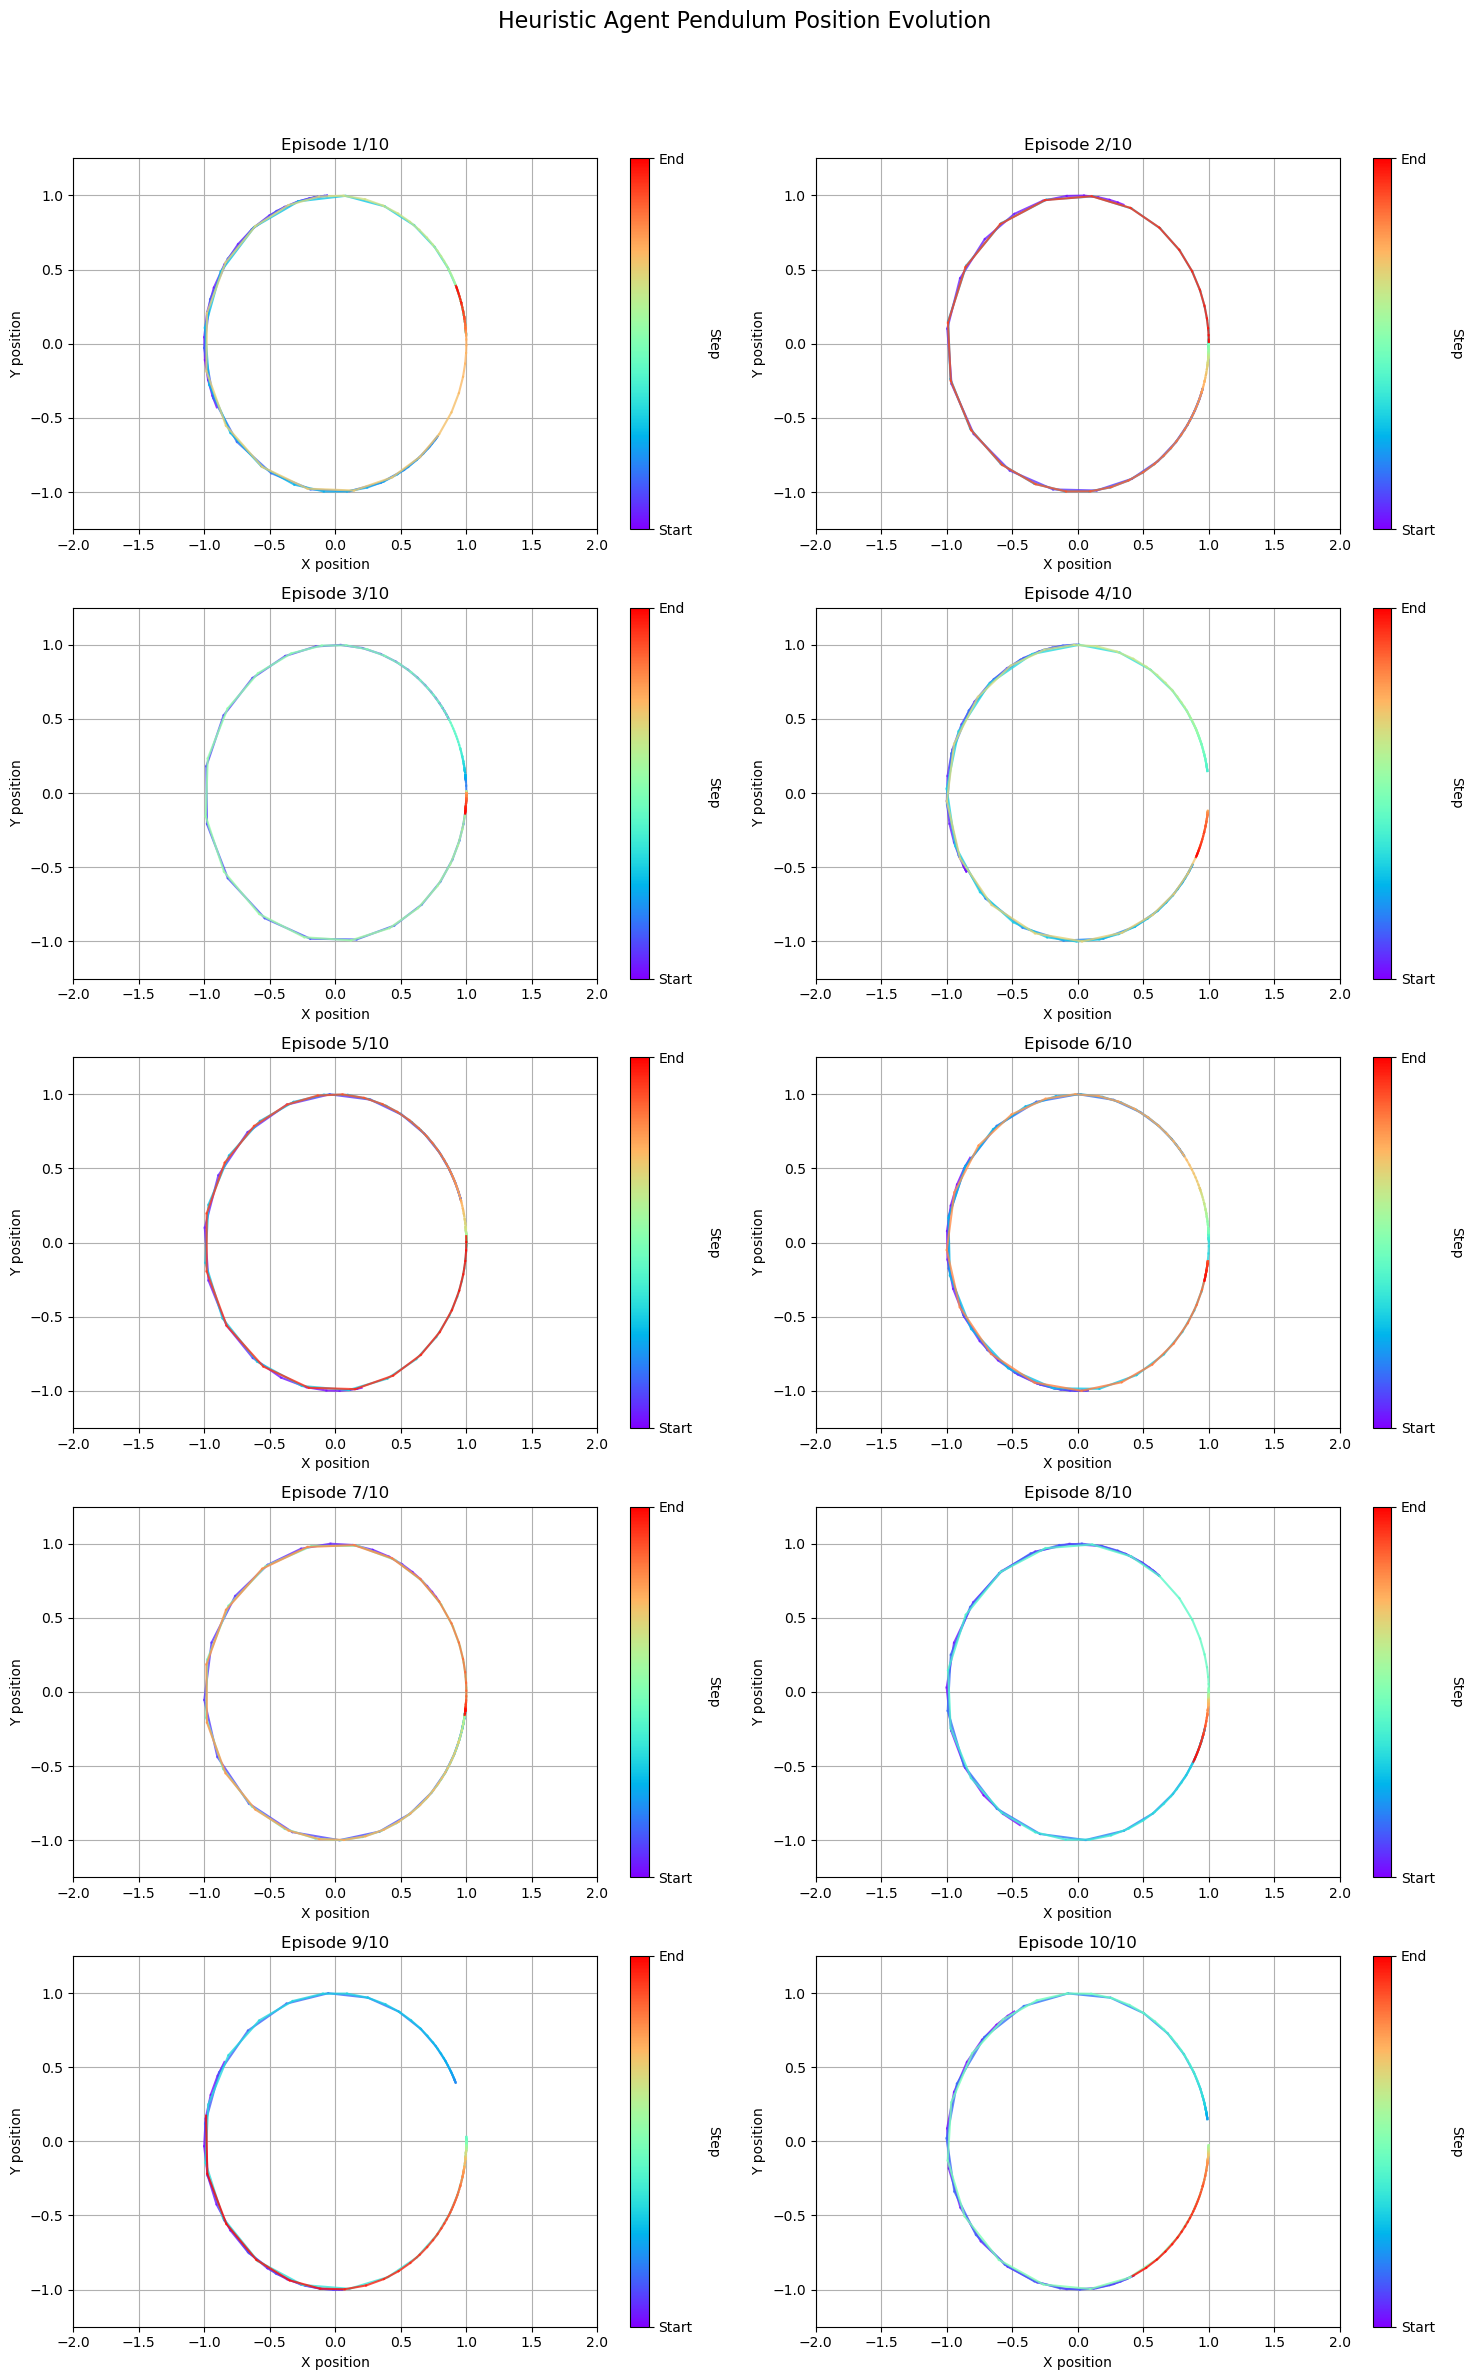

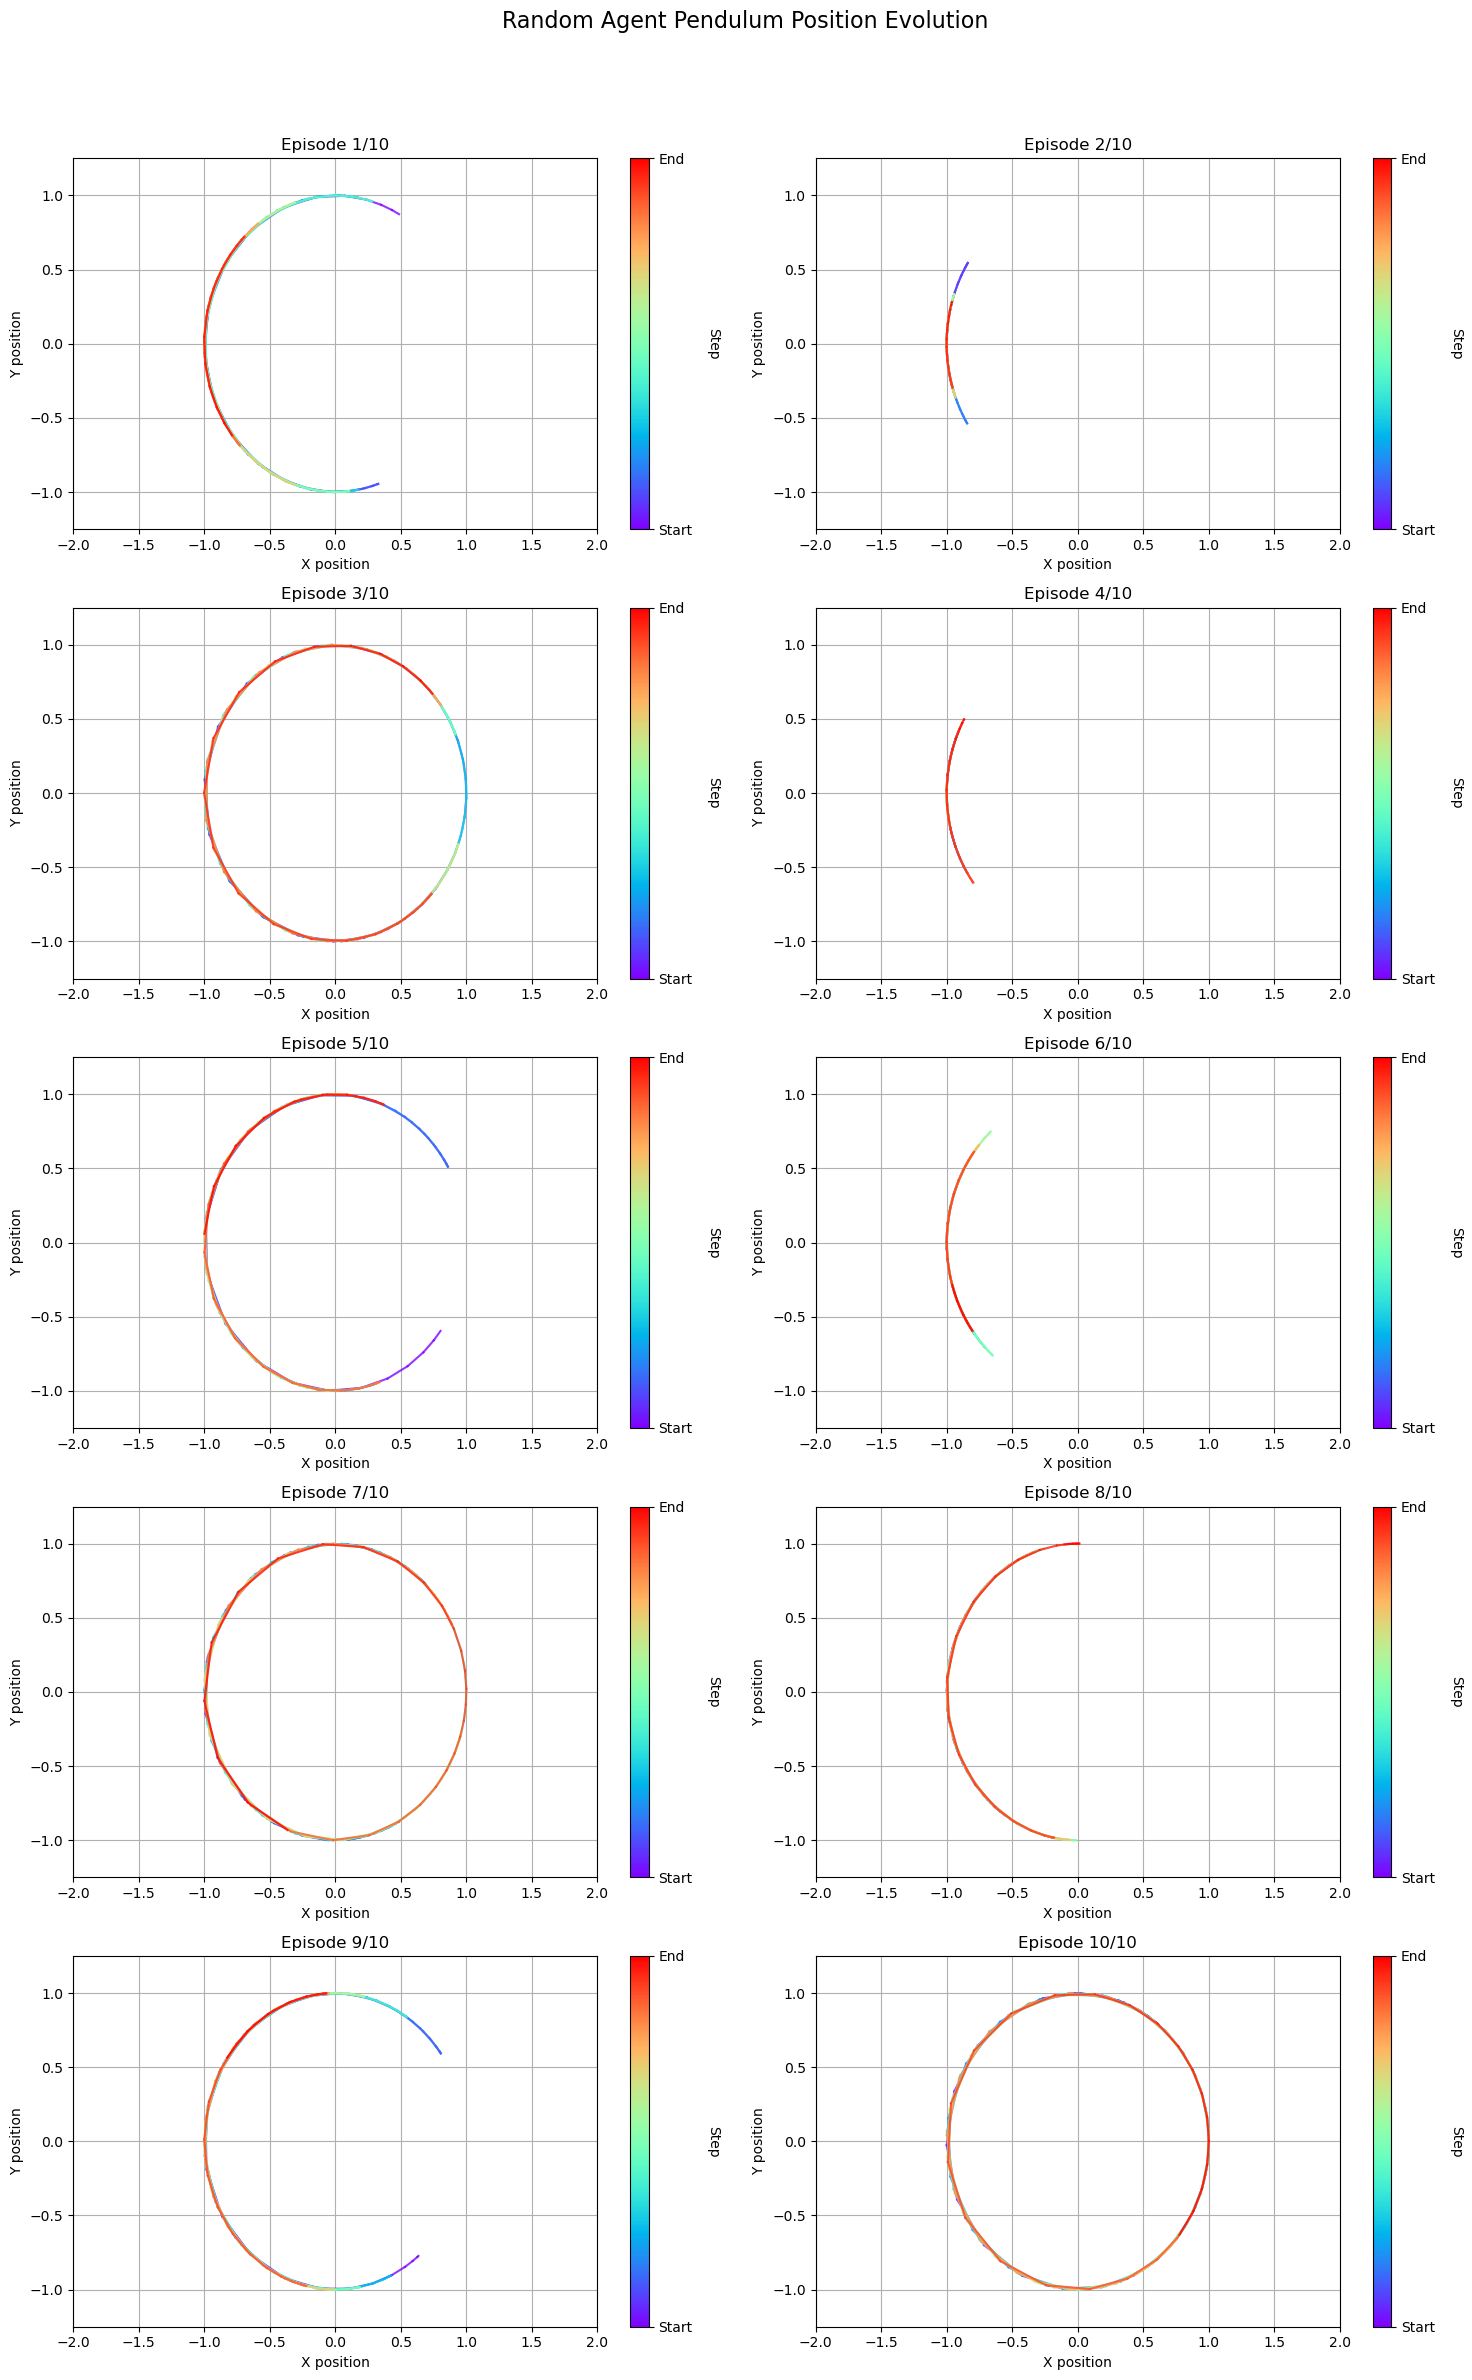

In [155]:
import matplotlib.cm as cm

def plot_positions(positions, agent_name):
    n_episodes = len(positions)
    nrows = (n_episodes + 1) // 2
    ncols = 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()

    for i, episode_positions in enumerate(positions, start=1):
        ax = axes[i - 1]
        x_values, y_values = zip(*episode_positions)

        n_points = len(x_values)
        colors = cm.rainbow(np.linspace(0, 1, n_points))

        for j in range(n_points - 1):
            ax.plot(x_values[j:j+2], y_values[j:j+2],
                    linestyle='-', color=colors[j], alpha=0.8)

        # Adding a colorbar as a legend for the gradient
        sm = plt.cm.ScalarMappable(
            cmap=cm.rainbow, norm=plt.Normalize(vmin=0, vmax=n_points))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, ticks=[0, n_points])
        cbar.ax.set_yticklabels(['Start', 'End'])
        cbar.ax.set_ylabel('Step', rotation=270, labelpad=20)

        ax.set_xlabel('X position')
        ax.set_ylabel('Y position')
        ax.set_xlim(-2, 2)
        ax.set_ylim(-1.25, 1.25)
        ax.set_title(f'Episode {i}/{n_episodes}')
        ax.grid()

    fig.suptitle(f'{agent_name} Pendulum Position Evolution', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Running agents with position storage
ha_avg_reward, ha_rewards, ha_positions = run_agent(heuristic_agent, env, store_positions=True)
ra_avg_reward, ra_rewards, ra_positions = run_agent(random_agent, env, store_positions=True)

# Plotting position evolution
plot_positions(ha_positions, 'Heuristic Agent')
plot_positions(ra_positions, 'Random Agent')

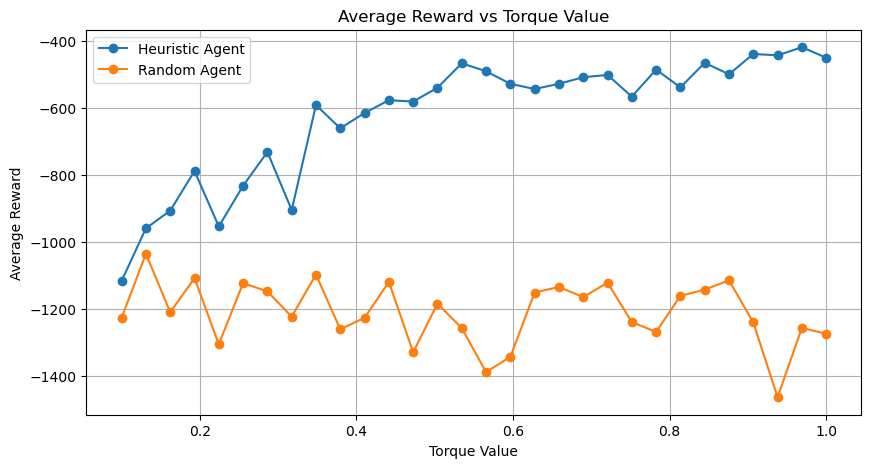

In [156]:
import matplotlib.pyplot as plt

def plot_rewards(torque_values, ha_rewards_list, ra_rewards_list):
    plt.figure(figsize=(10, 5))

    ha_means = [np.mean(rewards) for rewards in ha_rewards_list]
    ra_means = [np.mean(rewards) for rewards in ra_rewards_list]

    plt.plot(torque_values, ha_means, marker='o', label='Heuristic Agent')
    plt.plot(torque_values, ra_means, marker='o', label='Random Agent')

    plt.xlabel('Torque Value')
    plt.ylabel('Average Reward')
    plt.title('Average Reward vs Torque Value')
    plt.legend()
    plt.grid()
    plt.show()

    

torque_values = np.linspace(0.1, 1.0, 30)
ha_rewards_list = []
ra_rewards_list = []

for torque in torque_values:
    heuristic_agent = HeuristicPendulumAgent(env, fixed_torque=torque)
    ha_avg_reward, ha_rewards, _ = run_agent(heuristic_agent, env)
    ra_avg_reward, ra_rewards, _ = run_agent(random_agent, env)
    
    ha_rewards_list.append(ha_rewards)
    ra_rewards_list.append(ra_rewards)

plot_rewards(torque_values, ha_rewards_list, ra_rewards_list)


In [157]:
class ReplayBuffer:
    """ A buffer for storing transitions sampled from the environment. """
    def __init__(self, max_size, verbose=False):
        self.max_size = max_size
        self.transitions = []
        self.verbose = verbose
        
    def store(self, transition):
        """ Store a transition. """
        if self.verbose:
            print(f'Storing transition {transition}')
            
        if len(self.transitions) < self.max_size:
            self.transitions.append(transition)
        else:
            self.transitions.pop(0)
            self.transitions.append(transition)
        
    def sample(self, batch_size):
        """ Sample a batch of transitions. """
        batch = []
        for _ in range(batch_size):
            idx = np.random.randint(0, len(self.transitions))
            batch.append(self.transitions[idx])
            if self.verbose:
                print(f'Sampling transition {self.transitions[idx]}')
        return batch
    
    def __len__(self):
        return len(self.transitions)
    
        

In [158]:
class QNetwork(torch.nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.activation = nn.ReLU()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        """ Forward pass of the network. """
        x = x.view(-1, 4)   # -1 means infer this dimension
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)

        return x
        

In [159]:
def train_q_network(q_network, agent, transitions, optimizer, gamma, verbose=False):
    """
    Train Q-Network using 1-step TD-learning rule.

    Parameters:
    q_network (QNetwork): The Q-Network instance to be trained.
    transitions (list): A list of tuples containing the transitions used for training.
                        Each tuple should have the format (state, action, reward, next_state, trunc).
    optimizer (torch.optim.Optimizer): The optimizer used for updating the Q-Network's weights.
    gamma (float): The discount factor for future rewards (0 <= gamma <= 1).

    Returns:
    loss (float): The loss value after training the Q-Network with the given batch of transitions.
    """

    # Unpack transitions
    states, actions, rewards, next_states, trunc = zip(*transitions)
    next_actions = [agent.compute_action(next_state) for next_state in next_states]
    
    # Convert lists to PyTorch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.float32).unsqueeze(1).squeeze(2)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    next_actions = torch.tensor(
        next_actions, dtype=torch.float32).unsqueeze(1).squeeze(2)
    trunc = torch.tensor(trunc, dtype=torch.float32).unsqueeze(1)

    # Concatenate states and actions to form input to Q-network
    state_action_pairs = torch.cat([states, actions], dim=1)
    next_state_action_pairs = torch.cat([next_states, next_actions], dim=1)

    # Computes Q-values for the given state-action pairs
    q_values = q_network(state_action_pairs)

    # Compute target Q-values
    with torch.no_grad():
        q_targets = rewards + gamma * q_network(next_state_action_pairs) * (1 - trunc)

    # Compute loss
    #   Use MSE
    loss = torch.nn.functional.mse_loss(q_values, q_targets)

    # Perform backpropagation
    optimizer.zero_grad()   # Reset gradients to zero
    loss.backward()         # Compute gradients
    optimizer.step()        # Update weights

    if verbose:
        print(f'States:\n{states}')
        print(f'Actions:\n{actions}')
        print(f'Rewards:\n{rewards}')
        print(f'Next states:\n{next_states}')
        print(f'Trunc:\n{trunc}')
        print(f'State-action pair:\n{state_action_pairs}')
        print(f'Next state-action pair:\n{next_state_action_pairs}')
        print(f'Q-values:\n{q_values}')
        print(f'Target Q-values:\n{q_targets}')
        print(f'Loss: {loss.item()}')

    return loss.item()



In [160]:
def plot_polar_heatmap(q_network, action_velocity_pairs):
    n_points = 100
    theta = np.linspace(-np.pi, np.pi, n_points)
    q_values = np.zeros((len(action_velocity_pairs), n_points))

    for i, (action, velocity) in enumerate(action_velocity_pairs):
        for j, angle in enumerate(theta):
            state_action = torch.tensor([np.cos(angle), np.sin(
                angle), velocity, action], dtype=torch.float32)
            q_values[i, j] = q_network(state_action.unsqueeze(0)).item()

    fig, axes = plt.subplots(
        1, len(action_velocity_pairs), subplot_kw=dict(polar=True), figsize=(15, 5))

    for i, (action, velocity) in enumerate(action_velocity_pairs):
        c = axes[i].scatter(theta, np.ones_like(
            theta), c=q_values[i], cmap='coolwarm', vmin=-1, vmax=1)
        axes[i].set_title(f"Action: {action}, Velocity: {velocity}")
        axes[i].set_yticks([])

    fig.colorbar(c, ax=axes.ravel().tolist(), pad=0.1, aspect=30)
    plt.show()

In [162]:
replay_buffer = ReplayBuffer(max_size=1e4, verbose=False)
q_network = QNetwork()
optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-4)
heuristic_agent = HeuristicPendulumAgent(env, fixed_torque=1)

n_episodes = 3000
max_timesteps = 200
batch_size = 128
gamma = 0.99

episode_losses = []

for episode in range(n_episodes):
    clear_output(wait=True)
    print(f'Episode {episode + 1}/{n_episodes}')
    state, _ = env.reset()
    episode_loss = 0

    for t in range(max_timesteps):
        action = heuristic_agent.compute_action(state)
        next_state, reward, _, done,  _ = env.step(action)

        transition = (state, action, reward, next_state, done)
        replay_buffer.store(transition)

        if len(replay_buffer) >= batch_size:
            batch = replay_buffer.sample(batch_size)
            loss = train_q_network(q_network, heuristic_agent, batch, optimizer, gamma)
            episode_loss += loss

        state = next_state

        if done:
            break

    episode_losses.append(episode_loss)


Episode 3000/3000


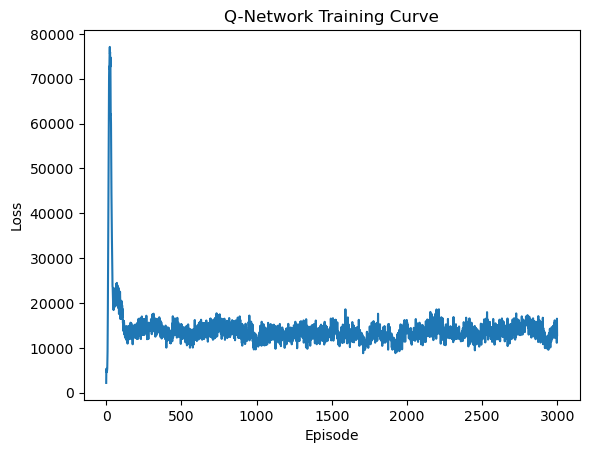

In [163]:
plt.plot(episode_losses)
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Q-Network Training Curve')
plt.show()
